# Natural Language Processing: Using Word Vectors for Textual Analysis

We've seen how neural nets and deep learning can help us answer questions relevant to natural language processing, like Name Entity Recognition. Today, we'll talk about a more basic process that underlies the work we did with  `spaCy` in the last lab, namely, the word2vec algorithm.

In this lab, we will:

*   Understand the goal behind word2vec
*   Visualize the complex relationships it can capture
*   See what word2vec is doing behind the scenes
*   Apply these complex relationships to solve a problem

This lab seeks to draw together a lot of disperate concepts and show you how neural nets, though they seem intimidating, are a logical outcome of the data science you have already seen in this course.



## What is word2vec

Before we dive into how it works, let's first take a look at what the goal of word2vec is. As the name implies, this very simple neural net seeks to transform words into vectors. As we will see, each unique word in a corpus will have an associated vector attached to it. This vector can be manipulated like any other vector, allowing us to apply complex mathematical operations to word meaning and sense.

In deep learning, this is called *feature extraction* because we are teaching a model how to extract the linguistic features from a word (though it could be anything, including images or audio). Feature extraction is rarely the end point in analysis. Instead, we can use these extracted features as the inputs to another model which will do some analysis. Before we get there though, let's look at how we can harness the power of word2vec.

In [ ]:
!pip install gensim datasets -Uq # this package handles word2vec for us

### The packages we'll need

`gensim` implements word2vec for us in an incredibly effiecent and parallelized manner. This means we don't even need to use GPUs or other advanced techniques to run it.

In this lab, we'll look at a collection of New York Times headlines that I created. It is a useful dataset, but we need to download it from a place called HuggingFace, using their `datasets` library. (If you're interested in how I built this dataset and how the `datasets` library works, let me know and I'd be happy to share the code with you)

But first, we're going to examine a pretrained model called GloVe wiki-gigaword-300, which is trained on a repository of wikipedia articles. Working with this model will give us good intuition for working with the NYT dataset at the end of the lab.

In [ ]:
!pip install numpy==1.26.0

In [ ]:
import gensim
from datasets import load_dataset

In [ ]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-300")  # takes about 3 minutes

In [ ]:
# this model takes in a word and gives back a vector (word TO vec)
model["obama"]

In [ ]:
type(model["obama"])

In [ ]:
model["obama"].shape

In [ ]:
# this model is from about 8 years ago so some things aren't covered
model["icespice"]

## Using word vectors

It's cool that we can turn text into numbers, but what can we do with them?



### Similarity measurement

The dot product (`np.dot` or `@`) tells us how similar two vectors are. The same is true for word vectors. The higher the number the stronger the relationship between the two vectors.

This is mathematically equivalent to:
${\displaystyle \mathbf {a} \cdot \mathbf {b} =\mathbf {a} ^{\mathsf {T}}\mathbf {b}}$

In [ ]:
import numpy as np

# strong relationship
obama_vector = model["obama"]
president_vector = model["president"]
obama_vector.T @ president_vector, np.dot(obama_vector, president_vector)

In [ ]:
# a less strong relationship
random_vector = model["random"]  # random word
obama_vector @ random_vector

In [ ]:
# cosine similarity, scaled version of the dot product
# this will ensure that values are between -1 and 1
president_scaled_sim = (
    obama_vector
    @ president_vector
    / (np.linalg.norm(obama_vector) * np.linalg.norm(president_vector))
)
random_scaled_sim = (
    obama_vector
    @ random_vector
    / (np.linalg.norm(obama_vector) * np.linalg.norm(random_vector))
)

print(president_scaled_sim, random_scaled_sim)

In [ ]:
# strongest relationships
# gensim docs: https://radimrehurek.com/gensim/models/keyedvectors.html
model.most_similar("obama")

### Visualizing word vectors

If you look online for word vectors, you may find 2-d or 3-d representations of word vectors. These can be very interesting to look at and can give us a good intuition for what the word2vec model is doing (before we see exactly what it's doing below).

In [ ]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# 2-d dimensionality reduction
svd = TruncatedSVD(2)
reduced = svd.fit_transform(model.vectors)

# putting into a dataframe
df = pd.DataFrame(list(zip(reduced, model.index_to_key)))
df["x"] = df[0].apply(lambda x: x[0])
df["y"] = df[0].apply(lambda x: x[1])
df = df.drop([0], axis=1)
df = df.rename(columns={1: "word"})
df

In [ ]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", hover_data=["word"])
fig.show()

In [ ]:
# taking a closer look
captials_countries = ["paris", "france", "london", "england", "rome", "italy"]
cc = df.loc[df.word.isin(captials_countries)]
fig = px.scatter(cc, x="x", y="y", hover_data=["word"])
fig.show()

We can see that there is an internal logic to these vectors that is detected just from the data itself. We didn't have to prompt or show the model anything. Instead, we just gave it the text and it figured out there is the same relationship between Paris and France as there is between London and England. Maybe you're starting to see why we sometimes call this 'artifical intelligence'.

#### TASK 1

Because these word vectors are just vectors that represent word meaning, we can do arithmetic on the vectors and expect to see a similar change in meaning. See the examples below and then try a set of semantic analogies for yourself.

In [ ]:
# ex1: what are toes minus feet plus hands?
# toes are to feet as hands are to ___
model.most_similar(positive=["toes", "hand"], negative=["feet"])

In [ ]:
# ex2: what is a king minus a man plus a woman?
# men are to kings as women are to ___
model.most_similar(positive=["king", "woman"], negative=["man"])

In [ ]:
# ex3: what is a turtle minus a shell plus teeth?
# shells are to turtles as teeth are to ___
model.most_similar(positive=["turtle", "teeth"], negative=["shell"])

In [ ]:
# try a couple out for yourself:
model.most_similar(positive=["moat", "swamp"], negative=["water"])

In [ ]:
# bonus: try to code this out without the `most similar` function, don't worry about the similarity score
# hint: if you have an index, you can find the word that goes with it with the model.index_to_key list

##### Answer

In [ ]:
p1 = model["king"]
p2 = model["woman"]
n1 = model["man"]

pos = np.add(p1, p2)
pos.shape

In [ ]:
sub = np.subtract(pos, n1)
sub.shape

In [ ]:
(400000, 300) x (300, 1) -> (400000, 1)

In [ ]:
sims = []
for v in range(400000):
    sims.append(model.vectors[v] @ sub.T)

In [ ]:
sim_scores = model.vectors @ sub.T
sim_scores.shape

In [ ]:
# without `most_similar`
def my_most_similar(model, positive=[], negative=[], to_see=10):
    pos = np.add(model[positive[0]], model[positive[1]])
    sub = np.subtract(pos, model[negative[0]])
    sim = (model.vectors @ sub.T).argsort()[::-1][:to_see]
    return [model.index_to_key[s] for s in sim]

In [ ]:
my_most_similar(model, positive=["toes", "hand"], negative=["feet"])

##  How does word2vec work?

This section will have a lot of explanation and some code, though I don't plan on explaining each line. If you'd like to see an example of word2vec coded out from scratch, let me know. Instead this section will focus on giving you an intuition on this is working.

### Training data

Before we can start training, we need to prepare our data for training. We already did one of these steps above, tokenization. In fact, when we prepared the data above, we followed all the right steps.

### Training objective
First, we need to better understand what the objective of word2vec is. We saw that it could take in some text and convert it into a vector. But this is, ironically, more of a byproduct of the training process than the goal.

Instead, word2vec seeks to predict the next word after a given word. (Then, the vectors we got above were the weights that the model predicted per unique word. See below.) To do so, we need to arrange our data in a format that lets us train in this way.



 ### Block size
`block_size` represents a moving context window which arranges our text into usable training data.


 Below is a diagram of this process using a `block_size` size of 2 (taken from: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).


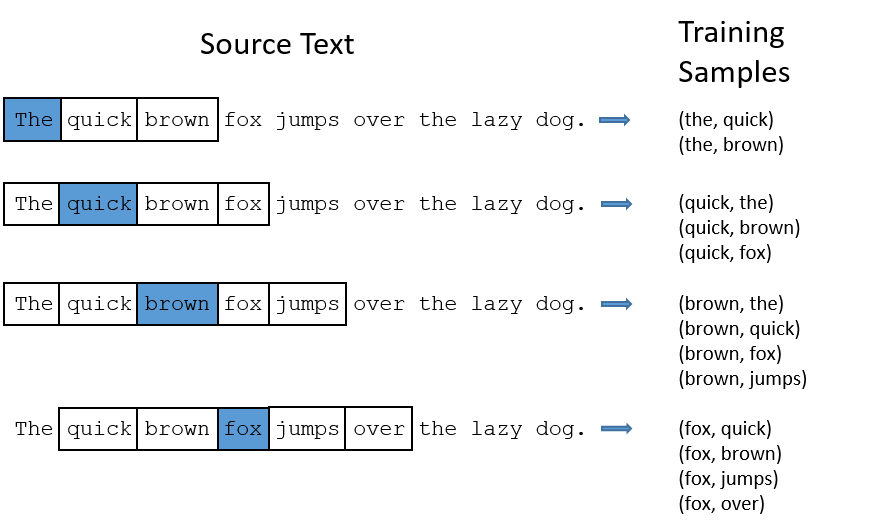


For the purposes of this model, we would take in the first members of these tuples and try to predict the second.

### Embedding layer

Now, how do we take the objective above and get the result we saw from `gensim`?

An embedding "layer" is just a data structure that holds all of the unique words in our texts and for each one has an arbitrarily log vector associated with it.

In [ ]:
from torch import nn

embedl = nn.Embedding(10, 100)  # this embedding has 10 words at 100 vectors long
embedl.weight.shape

In [ ]:
embedl.weight[0]  # random weights of a single "word"

Right now, these numbers are completely random, bur the training process will make them not random, so they will represent the meaning of the word they are assigned to.

### Linear layer

A linear layer is a fancy way of doing as many of the word-level ("what word comes next?") predictions at the same time and will look very familiar from linear regression:

$y_{pred} = xA^{\mathsf {T}}+b$, where $A$ is our embedding matrix. This *linear* transformation will give us the predictions for any piece of the data.

We can then compare these predictions to the correct values and train this model using gradient descent.

## Using word vectors for analysis

Now that we see how these vectors are created we can use them to answer a question. Specifically, we'll look at the entire NYT dataset and try to predict, based on just a headline, what section of the Times it's from.

In [ ]:
# loading in our (92k) headlines
ds = load_dataset("pnadel/nyt_headlines")
full = ds["train"].to_pandas()
hls = full.headline.to_list()
hls[:10], len(hls)

In [ ]:
full

In [ ]:
full.label.value_counts()

### Tokenization

Before we can turn our words into vectors, we need to *tokenize* our text. Tokenization is the process of turning our sentences into a list of words. Tokenization can be very complicated (with HuggingFace even providing a `tokenizers` library) but we'll keep it very simple for this example.

In [ ]:
from gensim.utils import simple_preprocess  # gensim's native tokenization function

simple_preprocess(hls[1])

In [ ]:
# using a list comprehension to tokenize our whole list
hls = [simple_preprocess(hl) for hl in hls]
hls[1]

### Model training

If we have a list of list of tokens (aka a list of tokenized sentences), `gensim` makes it really easy to train a word2vec model.

But what are all these parameters?

*   `vector_size`: the length of our word vectors, as we'll see the longer the vector the more linguistic information it can hold, but it also has a higher chance to overfit
*   `window`: this is the size of the context window that controls training data, we'll see this in more detail below
*   `min_count`: if a word occurs less than this number, it is ignored
*   `epochs`: how long to train the model, like `vector_size`, the higher the number the better the model, but it also has a higher chance to overfit.



In [ ]:
from gensim.models import Word2Vec

# training the model (~1 min)
model = Word2Vec(hls, vector_size=50, window=8, min_count=2, epochs=40)

In [ ]:
# vector representing 'biden'

In [ ]:
# vector representing 'president'
model.wv["president"], model.wv["president"].shape, type(model.wv["president"])

### Setting up our classification model

If we were to encode all the words in our headlines with their individual word embeddings, we wouldn't be able to train a classifier because the number of words in each headline varies. As a result, to compute a single vector for a headline, we'll just take the mean. This is a process called **mean pooling** and is very popular when create document-level embeddings. Can you think of why this might not be the best option in all cases? What are some alternatives?

I'll also do some data splits below. Hwere they are spelled out:

*   First split: `full_vector` -> `df` + `valid` (.33 split)
*   Second split: `df` -> `train` + `test` (.33 split)

At the end, we'll be left with three datasets. We'll train on `train`, test on `test` and then evaluate our classification model with `valid`.

#### TASK 2

As mentioned above, we need to take the mean of each set of embeddings of a headline. Below, try to do so by any means that makes sense to you.

Some useful variables:

*   `hls` - list of list of each word in each headline
*   `model` - calling `model.wv[word]` for any word will give you the embedding for that word

At the end, you should have a list of mean embeddings for each headline.



In [ ]:
# for each headline we want a 50 long vector that is the mean of all of its word embeddings

##### Answer

In [ ]:
s

In [ ]:
sent_vectors[0], hls[0]

#### DataFrames and Splits

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

full_vector = pd.DataFrame(sent_vectors)
full_vector["section"] = full["label"]

# first split
df, valid = train_test_split(full_vector, test_size=0.33, random_state=1337)
df

# second split
train, test = train_test_split(df, test_size=0.33, random_state=1337)
X_train = train[train.columns[:-1]]
X_test = test[test.columns[:-1]]

y_train = train[train.columns[-1]]
y_test = test[test.columns[-1]]

In [ ]:
df

In [ ]:
len(train), len(test), len(valid)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr_model = lr.fit(X_train, y_train)

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
# simple accuracy on test set
(y_pred == y_test).sum() / len(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)  # takes about 30 seconds

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
# simple accuracy
(y_pred == y_test).sum() / len(y_pred)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

In [ ]:
# check on our validation set
X_v = valid[valid.columns[:-1]]
y_v = valid[valid.columns[-1]]

In [ ]:
v_pred = rf_model.predict(X_v)

In [ ]:
# simple accuracy
(v_pred == y_v).sum() / len(v_pred)

In [ ]:
cm = confusion_matrix(y_v, v_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()

In [ ]:
# check where we're wrong
check = pd.DataFrame(
    {"headline": full.headline.iloc[y_v.index], "true": y_v, "pred": v_pred}
)
wrong = check.loc[check.true != check.pred]

In [ ]:
p = wrong.sample(5).apply(
    lambda x: print(
        f"Text: {x['headline']}\nTrue Label: {x['true']}\nPredicted Label: {x['pred']}\n---------"
    ),
    axis=1,
)

# Conclusion

Language modeling can, at times, be very complicated and very simple. As we saw, the word2vec model attempts to recreate the simple logic that we all have while reading a text, yet the details of individual choices can still seem mystifying.

View this notebooks as an invitation into the realm of natural language processing. I find that online resources for NLP range from incredibly informative to almost worthless, so I've provided some links below to some places to visit if you're interested in learning more:

*   [Andrej Karpathy's Youtube account](https://www.youtube.com/@AndrejKarpathy) is an amazing resource for learning how to design NLP models of the generation after Word2Vec.
*   [Jeremy Howard's fast.ai course](https://course.fast.ai/) is designed for data scientists to learn about deep learning.
* [HuggingFace's NLP course](https://huggingface.co/course/chapter1/1) gives a practical walk through for the HuggingFace NLP framework.

And as always, you can feel free to email me with a question or to set up a meeting at peter.nadel@tufts.edu.
